This solution accelerator notebook is available at [Databricks Industry Solutions](https://github.com/databricks-industry-solutions/supply-chain-stress-test).

# Stress-Test Small Networks and Analyze the Results

This notebook demonstrates how to run stress tests on a small supply chain network and analyze the results. We will introduce two key concepts—time-to-recover (TTR) and time-to-survive (TTS)—which are essential for understanding the risk exposure of disruption scenarios.

## Cluster Configuration
This notebook was tested on the following Databricks cluster configuration:
- **Databricks Runtime Version:** 16.4 LTS ML (includes Apache Spark 3.5.2, Scala 2.12)
- **Single Node** 
    - Azure: Standard_DS4_v2 (28 GB Memory, 8 Cores)
    - AWS: m5d.2xlarge (32 GB Memory, 8 Cores)
- **Photon Acceleration:** Disabled (Photon boosts Apache Spark workloads; not all ML workloads will see an improvement)

In [0]:
%pip install -r ./requirements.txt --quiet
dbutils.library.restartPython()

Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.


In [0]:
import os
import mlflow
import random
import numpy as np
import pandas as pd
import pyomo.environ as pyo
import scripts.utils as utils

## Generate Dataset

As in the previous notebook, we will generate a supply chain network along with the corresponding operational data.

In [0]:
# Generate a synthetic 3-tier supply chain network dataset for optimization
# N1: number of product nodes
# N2: number of direct supplier nodes
# N3: number of sub-supplier nodes
dataset = utils.generate_data(N1=5, N2=10, N3=20) # DO NOT CHANGE

## Multi-Tier Time-to-Recover (TTR) Model

TTR (Time-to-Recover) is a key input to the optimization problem. It represents the time required for a node—or a group of nodes—to return to normal operations after a disruption. TTR is typically obtained from suppliers or estimated through internal assessments.

In stress testing, we simulate disruptive scenarios in which one or more nodes fail. A failure can be either partial or complete and lasts for the duration of the TTR. In this solution accelerator, we simulate complete failures for each node. This is modeled by temporarily removing the node and re-optimizing the network based on the new topology. The objective function can be defined flexibly based on your business goals. In this exercise, we define it as the total lost profit across all products, which we aim to minimize. For the detailed formulation and model specification, see the function `utils.build_and_solve_multi_tier_ttr` in the script `scripts/utils.py` or refer to the notebook `04_appendix`.

After finding the optimized configuration—through material and inventory reallocation and production adjustments—we obtain the cumulative lost profit incurred during the TTR period. This quantifies the impact of each disruption scenario. We repeat this process for all nodes to compare and assess the relative risk exposure associated with each one. 


In [0]:
# Assign a random TTR to each disrupted node; in practice, TTR is a predefined input variable
random.seed(777) # DO NOT CHANGE!
disrupted_nodes = {node: random.randint(1, 10) for node in dataset['tier2'] + dataset['tier3']}

We iterate through all nodes in Tier 2 and Tier 3 and simulate their respective disruption events.

In [0]:
lost_profit = []
for disrupted_node in disrupted_nodes:
    disrupted = [disrupted_node]
    df = utils.build_and_solve_multi_tier_ttr(dataset, disrupted, disrupted_nodes[disrupted_node])
    lost_profit.append(df)

lost_profit = pd.concat(lost_profit, ignore_index=True)
display(lost_profit)

disrupted,ttr,termination_condition,lost_profit
List(T2_1),4,optimal,0.0
List(T2_2),8,optimal,509.0
List(T2_3),8,optimal,366.38000000000005
List(T2_4),6,optimal,0.0
List(T2_5),10,optimal,663.34
List(T2_6),5,optimal,68.85
List(T2_7),6,optimal,310.5
List(T2_8),9,optimal,1601.38
List(T2_9),1,optimal,0.0
List(T2_10),8,optimal,1808.0700000000002


The result above indicates that not every failure leads to a finite lost profit. The magnitude of lost profit is influenced by several factors, including inventory levels, production capacity, supplier diversification, TTR, and more.

### Highest Risk Nodes
Let's examine the top 5 nodes with the highest lost profit. We'll visualize the network again to help interpret the results more intuitively.

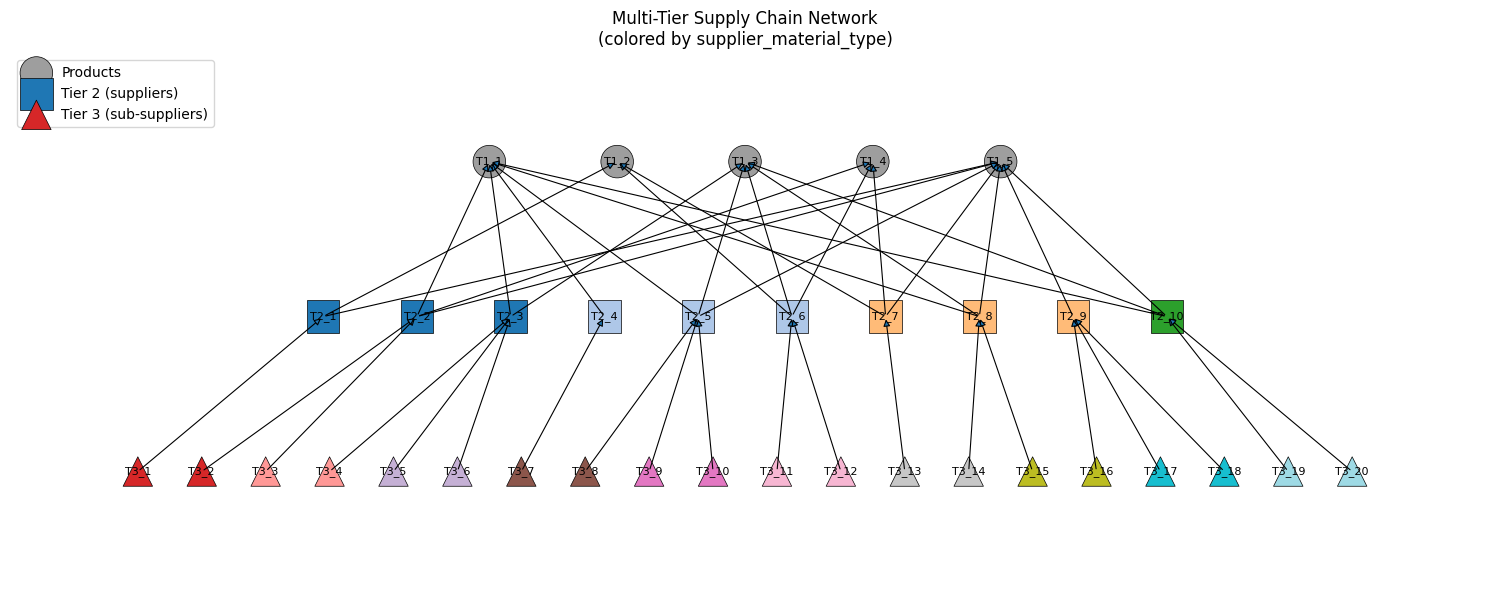

disrupted,ttr,termination_condition,lost_profit
List(T2_10),8,optimal,1808.0700000000002
List(T2_8),9,optimal,1601.38
List(T3_15),10,optimal,1339.2
List(T2_5),10,optimal,663.34
List(T2_2),8,optimal,509.0


In [0]:
# Visualizes the 3-tier network
utils.visualize_network(dataset)

highest_risk_nodes = lost_profit.sort_values(by="lost_profit", ascending=False)[0:5]
display(highest_risk_nodes)

Having `T2_10` as the node with the highest risk exposure is not surprising, as it is the sole supplier of a specific material type. If this node fails, the production of `T1_1`, `T1_3`, and `T1_5` will halt once existing inventory is depleted.

`T2_8` is a more subtle case. At first glance, its high risk is not obvious. However, upon examining the nodes it supplies—`T1_1`, `T1_3`, and `T1_5`—we see that for `T1_1` and `T1_3`, `T2_8` is the only source of a specific material. This means its failure directly halts production at those nodes.

For the same reason, `T3_15` is also a high-risk node, with disruption effects that propagate across multiple tiers. `T3_14` is in a similar situation; however, its TTR is 5—significantly shorter than `T3_15`'s TTR of 10. As a result, `T3_14` does not appear on the riskiest node list.

Let's take a closer look at a specific failure scenario by inspecting the values of the decision variables identified by the linear solver. In the `utils.build_and_solve_multi_tier_ttr` function, you can set the parameter `return_model=True` to retrieve the model and access the decision variable values. Let's look into the `T2_8` failure.


In [0]:
scenario = "T2_8"

# Solve the multi-tier TTR model for the given scenario
df = utils.build_and_solve_multi_tier_ttr(dataset, [scenario], disrupted_nodes[scenario], True)
model = df["model"].values[0]
records = []
for v in model.component_data_objects(ctype=pyo.Var, active=True):
    idx  = v.index()
    record  = {
        "var_name"  : v.parent_component().name,
        "index"     : idx,
        "value"     : pyo.value(v),
    }
    records.append(record)

In [0]:
demand = pd.DataFrame.from_dict(dataset["d"], orient='index').reset_index()
demand = demand.rename(columns={"index": "node", 0: "demand"})
demand["demand"] *= disrupted_nodes[scenario]

prod = pd.DataFrame([record for record in records if record["var_name"] == "u"])
prod = prod.rename(columns={"index": "node", "value": "production"})
prod = prod.drop("var_name", axis=1).sort_values(by="node").reset_index(drop=True)

stock = pd.DataFrame.from_dict(dataset["s"], orient='index').reset_index()
stock = stock.rename(columns={"index": "node", 0: "stock"})

lost = pd.DataFrame([record for record in records if record["var_name"] == "l"])
lost = lost.drop("var_name", axis=1).rename(columns={"index": "node", "value": "lost_demand"})

merged = demand.merge(prod, on="node", how="right")
merged = merged.merge(stock, on="node")
merged = merged.merge(lost, on="node", how="left")

display(merged)

node,demand,production,stock,lost_demand
T1_1,7209.0,1569.0,1630,4010.0
T1_2,7623.0,5025.0,2598,0.0
T1_3,7443.0,-0.0,2306,5137.0
T1_4,7389.0,4741.0,2648,0.0
T1_5,7029.0,4874.0,2155,0.0
T2_1,null,14463.0,2127,null
T2_10,null,16272.0,2465,null
T2_2,null,20834.0,1884,null
T2_3,null,14481.0,1693,null
T2_4,null,20385.0,1853,null


The first thing to notice in the output above is that the production volume of `T2_8` is zero due to the simulated failure (`production`). Next, we observe losses at `T1_1` and `T1_3` (`lost_demand`). In the case of `T1_3`, there is no production, so once the existing stock is depleted, the remaining demand directly becomes lost demand. For `T1_1`, it appears that all of `T2_8`'s inventory (1,569 units) was routed to this node, allowing some production to continue. The solver prioritized `T1_1` because it has a higher profit margin than `T1_3` (as shown in the `01_operational_data` notebook).

## Multi-Tier Time-to-Survive (TTS) Model

Time-to-Survive (TTS) provides a complementary perspective on the risk associated with node failures. Unlike TTR, TTS is not an input but an output—a decision variable. When a disruption affects a node or group of nodes, TTS represents the amount of time the reconfigured network can continue to meet demand without incurring any loss. The risk becomes more critical when TTR exceeds TTS by a significant margin.

The TTS model closely resembles the TTR model, with minor modifications to the objective function and constraints. For more details, see the function `utils.build_and_solve_multi_tier_tts` in the script `scripts/utils.py` or refer to the `04_appendix` notebook.

Let's again iterate through all nodes in Tier 2 and Tier 3.

In [0]:
tts = []
for disrupted_node in disrupted_nodes:
    disrupted = [disrupted_node]
    df = utils.build_and_solve_multi_tier_tts(dataset, disrupted)
    df["ttr"] = disrupted_nodes[disrupted_node]
    tts.append(df)

# Concatenate all dataframes in the list into a single dataframe
tts = pd.concat(tts, ignore_index=True)

Now, let's show where TTS is shorter than TTR.

In [0]:
# Show where tts is shorter than ttr
display(tts[tts["tts"] < tts["ttr"]])

disrupted,termination_condition,tts,ttr
List(T2_2),optimal,5.519846350832267,8
List(T2_3),optimal,4.835550181378476,8
List(T2_5),optimal,5.003627569528416,10
List(T2_6),optimal,4.724304715840387,5
List(T2_7),optimal,4.758830694275274,6
List(T2_8),optimal,3.380894800483676,9
List(T2_10),optimal,3.551390568319226,8
List(T3_1),optimal,8.76696542893726,10
List(T3_2),optimal,8.007083825265644,9
List(T3_4),optimal,7.309552599758162,10


The result above highlights all (sub)supplier sites where the time-to-recover (TTR) exceeds the time-to-survive (TTS). To enhance network resiliency, these nodes can be reassessed. Potential actions include reducing TTR through supplier renegotiations, increasing TTS by building inventory buffers, or diversifying the sourcing strategy.


## Wrap Up

In this notebook, we demonstrated how to run stress tests on a small supply chain network and analyze the results. We introduced two key concepts—time-to-recover (TTR) and time-to-survive (TTS)—and applied them in our analysis.

In the next notebook, `03_stress_testing (large network)`, we will run similar stress tests on a much larger network consisting of thousands of nodes.


&copy; 2025 Databricks, Inc. All rights reserved. The source in this notebook is provided subject to the Databricks License [https://databricks.com/db-license-source].  All included or referenced third party libraries are subject to the licenses set forth below.

| library                                | description             | license    | source                                              |
|----------------------------------------|-------------------------|------------|-----------------------------------------------------|
| pyomo | An object-oriented algebraic modeling language in Python for structured optimization problems | BSD-3 | https://pypi.org/project/pyomo/
| highspy | Linear optimization solver (HiGHS) | MIT | https://pypi.org/project/highspy/
| ray | Framework for scaling AI/Python applications | Apache 2.0 | https://github.com/ray-project/ray